<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_for_odd_sized_images_ver14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [0]:
from IPython.display import Image
from keras.utils import plot_model
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

In [0]:
from IPython.display import Image
from keras.utils import plot_model

In [0]:
# Restart runtime to allow Jupyter to know the changes above
import os
#os._exit(0)

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average, merge
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

In [0]:
def load_dataold():
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,28,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([28,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
def load_large_data5656():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
X_trainlarge = load_large_data()

In [0]:
X_trainlarge5656 = load_large_data5656()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  if (datasetname == 3):   
     X_train = X_trainlarge
  if (datasetname == 4):   
     X_train = X_trainlarge5656

  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
  #  print("-- Discriminator -- ")
   # model.summary()
    return model

In [0]:
def build_discriminator2856(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:


def plotamodel(amodel, showdetails=True):
  # Model summary
  print(amodel.summary())

  if (showdetails==True):
    # Plot model graph
    plot_model(amodel, show_shapes=True, show_layer_names=True, to_file='model.png')
    #Image(retina=True, filename='model.png')
  if (showdetails==False):
    # Plot model graph
    plot_model(amodel, show_shapes=False, show_layer_names=False, to_file='modelsmall.png')
   # Image(retina=True, filename='modelsmall.png')

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(2)
    X_train5656 = None
    
    if modeltotrain == 3:
          X_train5656 = load_databydatasetname(3)

    num_examples = X_train.shape[0] / 2
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
        
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            if modeltotrain == 2:
              fake_images = fake_images2
              fake_labels = fake_labels2
            if modeltotrain == 3:
              noise2 = copy.deepcopy(noise1)
              fake_images3 = mergedmodel.predict(noise2)
              fake_labels3 = np.zeros((half_batch, 1))    
              fake_images = fake_images3
              fake_labels = fake_labels3              
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            X_train = X_trainlarge
            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)            
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNEW(averagemode = 1, loadpretrainedweights=False):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 56, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    if(averagemode == 1):
          models = [generator1, generator1]
    if(averagemode == 2):
          models = [generator2, generator2]
    if(averagemode == 3):
          models = [generator1, generator2]


  ##  models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    for obj1 in outputs:
      print(type(obj1))
      print(obj1.shape)
        
    mergedlayer = Concatenate(axis=2)(outputs)
    ##x = merge([lstm_out, auxiliary_input], mode='concat')
   ## output = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)
  #  mergedlayer = merge([generator1, generator2], mode='concat', concat_axis=1)
  
   #mergedlayer = merge([out1, out], mode='concat', concat_axis=1)
#contact axis can be -1 to 0 , 1 for inception , 2 , 3 or remove it
  #  mergedlayer = merge([generator1, generator1])

    print('merge layers')
    print(out1.shape)
    print(out.shape)
    print(mergedlayer.shape)

  

    
    
    mergedmodel = Model(z, mergedlayer)
    
    discriminator.trainable = False
    real = discriminator(mergedlayer)
    combined = Model(z, real)
        

    
    if(loadpretrainedweights==True):
     # generator1 = generator1.load_weights('generator2fmnist.h5')
     # generator2 = generator2.load_weights('generator2fmnist.h5')
      generator1 = load_model('generator2fmnist.h5')
      generator2 = load_model('generator2fmnist.h5')
      

    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer) 
  
    plotamodel(mergedmodel)
   # plotamodel(combined)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 1 ,  loadpretrainedweights=False)




    
    

    


In [0]:
plotamodel(combined)
files.download('model.png')




In [0]:
plotamodel(discriminator)
files.download('model.png')




In [0]:
#train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

Epoch 2 Batch 621/937 [D loss: 0.092790, acc.: 96.88%] [G loss: 5.317442]
Epoch 2 Batch 622/937 [D loss: 0.028294, acc.: 100.00%] [G loss: 5.357599]
Epoch 2 Batch 623/937 [D loss: 0.029215, acc.: 100.00%] [G loss: 4.819948]
Epoch 2 Batch 624/937 [D loss: 0.239007, acc.: 93.75%] [G loss: 4.080883]
Epoch 2 Batch 625/937 [D loss: 0.261958, acc.: 90.62%] [G loss: 4.662579]
Epoch 2 Batch 626/937 [D loss: 0.232492, acc.: 93.75%] [G loss: 4.655686]
Epoch 2 Batch 627/937 [D loss: 0.028317, acc.: 100.00%] [G loss: 3.720285]
Epoch 2 Batch 628/937 [D loss: 0.360604, acc.: 93.75%] [G loss: 3.352431]
Epoch 2 Batch 629/937 [D loss: 0.183337, acc.: 93.75%] [G loss: 4.588815]
Epoch 2 Batch 630/937 [D loss: 0.036117, acc.: 100.00%] [G loss: 5.420387]
Epoch 2 Batch 631/937 [D loss: 0.240293, acc.: 96.88%] [G loss: 4.515921]
Epoch 2 Batch 632/937 [D loss: 0.044064, acc.: 100.00%] [G loss: 4.730337]
Epoch 2 Batch 633/937 [D loss: 0.150270, acc.: 93.75%] [G loss: 4.011775]
Epoch 2 Batch 634/937 [D loss: 0.

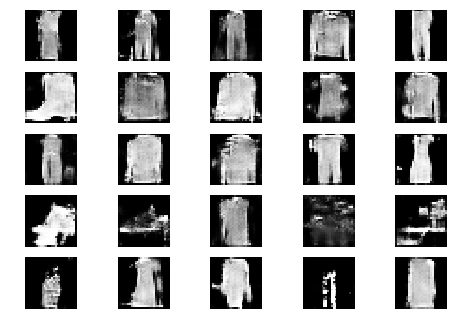

Epoch 2 Batch 701/937 [D loss: 0.046835, acc.: 100.00%] [G loss: 5.686994]
Epoch 2 Batch 702/937 [D loss: 0.230858, acc.: 93.75%] [G loss: 4.783646]
Epoch 2 Batch 703/937 [D loss: 0.128407, acc.: 93.75%] [G loss: 4.957013]
Epoch 2 Batch 704/937 [D loss: 0.037512, acc.: 100.00%] [G loss: 6.376283]
Epoch 2 Batch 705/937 [D loss: 0.032114, acc.: 100.00%] [G loss: 5.811772]
Epoch 2 Batch 706/937 [D loss: 0.329606, acc.: 93.75%] [G loss: 4.720740]
Epoch 2 Batch 707/937 [D loss: 0.595675, acc.: 84.38%] [G loss: 3.836861]


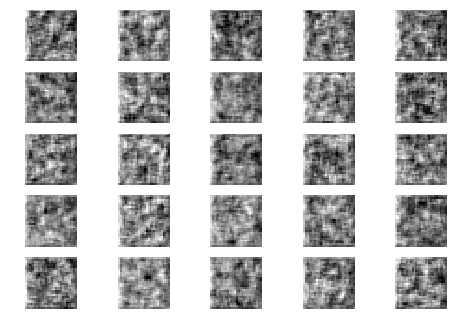

Epoch 2 Batch 708/937 [D loss: 0.319420, acc.: 87.50%] [G loss: 6.342545]
Epoch 2 Batch 709/937 [D loss: 0.389021, acc.: 90.62%] [G loss: 6.803503]
Epoch 2 Batch 710/937 [D loss: 0.335831, acc.: 90.62%] [G loss: 3.896096]
Epoch 2 Batch 711/937 [D loss: 0.222334, acc.: 93.75%] [G loss: 4.606052]
Epoch 2 Batch 712/937 [D loss: 0.023475, acc.: 100.00%] [G loss: 5.410311]
Epoch 2 Batch 713/937 [D loss: 0.027007, acc.: 100.00%] [G loss: 4.976706]
Epoch 2 Batch 714/937 [D loss: 0.023822, acc.: 100.00%] [G loss: 5.509913]


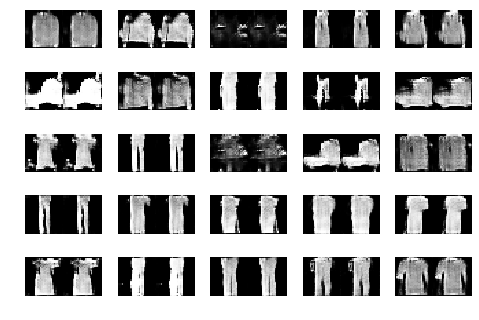

Epoch 2 Batch 715/937 [D loss: 0.013891, acc.: 100.00%] [G loss: 5.649437]
Epoch 2 Batch 716/937 [D loss: 0.038489, acc.: 100.00%] [G loss: 5.516168]
Epoch 2 Batch 717/937 [D loss: 0.167338, acc.: 90.62%] [G loss: 5.071943]
Epoch 2 Batch 718/937 [D loss: 0.213145, acc.: 90.62%] [G loss: 4.839725]
Epoch 2 Batch 719/937 [D loss: 0.105181, acc.: 90.62%] [G loss: 5.497385]
Epoch 2 Batch 720/937 [D loss: 0.130418, acc.: 90.62%] [G loss: 5.825266]
Epoch 2 Batch 721/937 [D loss: 0.275067, acc.: 93.75%] [G loss: 4.472335]
Epoch 2 Batch 722/937 [D loss: 0.215809, acc.: 90.62%] [G loss: 4.985955]
Epoch 2 Batch 723/937 [D loss: 0.020911, acc.: 100.00%] [G loss: 4.621171]
Epoch 2 Batch 724/937 [D loss: 0.096893, acc.: 93.75%] [G loss: 4.622250]
Epoch 2 Batch 725/937 [D loss: 0.115070, acc.: 93.75%] [G loss: 4.568117]
Epoch 2 Batch 726/937 [D loss: 0.026509, acc.: 100.00%] [G loss: 4.534379]
Epoch 2 Batch 727/937 [D loss: 0.131019, acc.: 96.88%] [G loss: 4.650647]
Epoch 2 Batch 728/937 [D loss: 0.0

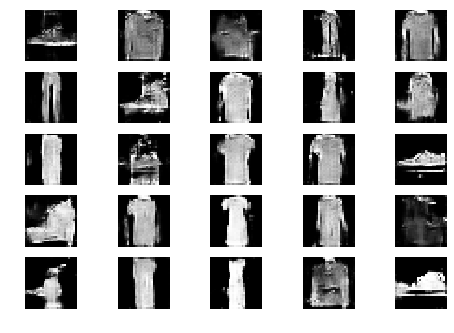

Epoch 2 Batch 801/937 [D loss: 0.025385, acc.: 100.00%] [G loss: 4.643800]
Epoch 2 Batch 802/937 [D loss: 0.109503, acc.: 93.75%] [G loss: 4.709425]
Epoch 2 Batch 803/937 [D loss: 0.164340, acc.: 96.88%] [G loss: 4.966671]
Epoch 2 Batch 804/937 [D loss: 0.228021, acc.: 84.38%] [G loss: 4.059985]
Epoch 2 Batch 805/937 [D loss: 0.054143, acc.: 100.00%] [G loss: 5.477759]
Epoch 2 Batch 806/937 [D loss: 0.176264, acc.: 87.50%] [G loss: 4.619563]
Epoch 2 Batch 807/937 [D loss: 0.106865, acc.: 96.88%] [G loss: 4.595963]
Epoch 2 Batch 808/937 [D loss: 0.101643, acc.: 96.88%] [G loss: 6.696441]


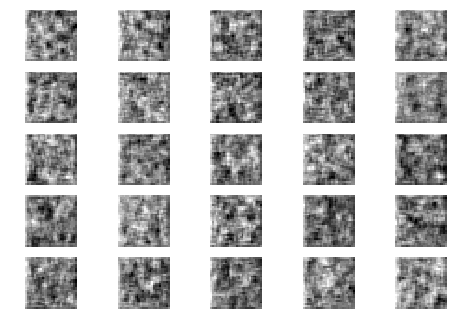

Epoch 2 Batch 809/937 [D loss: 0.162038, acc.: 96.88%] [G loss: 5.732724]
Epoch 2 Batch 810/937 [D loss: 0.204451, acc.: 96.88%] [G loss: 5.426555]
Epoch 2 Batch 811/937 [D loss: 0.226847, acc.: 90.62%] [G loss: 5.235098]
Epoch 2 Batch 812/937 [D loss: 0.149134, acc.: 93.75%] [G loss: 5.364824]
Epoch 2 Batch 813/937 [D loss: 0.119171, acc.: 96.88%] [G loss: 5.797226]
Epoch 2 Batch 814/937 [D loss: 0.045049, acc.: 100.00%] [G loss: 4.857176]
Epoch 2 Batch 815/937 [D loss: 0.007696, acc.: 100.00%] [G loss: 5.553434]
Epoch 2 Batch 816/937 [D loss: 0.103097, acc.: 96.88%] [G loss: 5.772463]


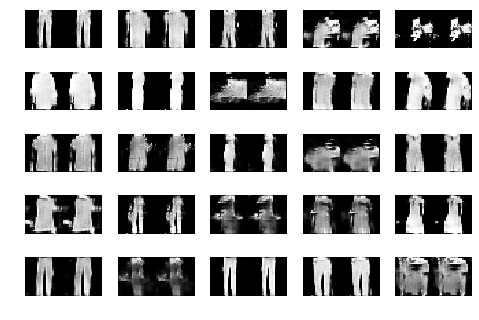

Epoch 2 Batch 817/937 [D loss: 0.025040, acc.: 100.00%] [G loss: 3.795451]
Epoch 2 Batch 818/937 [D loss: 0.056563, acc.: 100.00%] [G loss: 4.903284]
Epoch 2 Batch 819/937 [D loss: 0.068924, acc.: 96.88%] [G loss: 4.420072]
Epoch 2 Batch 820/937 [D loss: 0.147159, acc.: 90.62%] [G loss: 5.288967]
Epoch 2 Batch 821/937 [D loss: 0.165790, acc.: 93.75%] [G loss: 4.366245]
Epoch 2 Batch 822/937 [D loss: 0.097126, acc.: 96.88%] [G loss: 4.735447]
Epoch 2 Batch 823/937 [D loss: 0.146141, acc.: 96.88%] [G loss: 6.001919]
Epoch 2 Batch 824/937 [D loss: 0.137323, acc.: 96.88%] [G loss: 4.757399]
Epoch 2 Batch 825/937 [D loss: 0.156246, acc.: 93.75%] [G loss: 4.393417]
Epoch 2 Batch 826/937 [D loss: 0.050614, acc.: 96.88%] [G loss: 4.841397]
Epoch 2 Batch 827/937 [D loss: 0.195974, acc.: 96.88%] [G loss: 5.933040]
Epoch 2 Batch 828/937 [D loss: 0.237109, acc.: 90.62%] [G loss: 5.282799]
Epoch 2 Batch 829/937 [D loss: 0.004693, acc.: 100.00%] [G loss: 5.304305]
Epoch 2 Batch 830/937 [D loss: 0.01

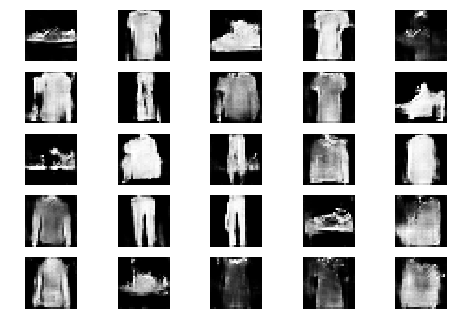

Epoch 2 Batch 901/937 [D loss: 0.016326, acc.: 100.00%] [G loss: 4.651610]
Epoch 2 Batch 902/937 [D loss: 0.019798, acc.: 100.00%] [G loss: 5.183387]
Epoch 2 Batch 903/937 [D loss: 0.068133, acc.: 96.88%] [G loss: 5.419379]
Epoch 2 Batch 904/937 [D loss: 0.145896, acc.: 93.75%] [G loss: 5.493285]
Epoch 2 Batch 905/937 [D loss: 0.150770, acc.: 93.75%] [G loss: 5.558112]
Epoch 2 Batch 906/937 [D loss: 0.093964, acc.: 96.88%] [G loss: 6.603190]
Epoch 2 Batch 907/937 [D loss: 0.087591, acc.: 96.88%] [G loss: 6.142205]
Epoch 2 Batch 908/937 [D loss: 0.103133, acc.: 96.88%] [G loss: 6.121056]
Epoch 2 Batch 909/937 [D loss: 0.012887, acc.: 100.00%] [G loss: 6.143202]


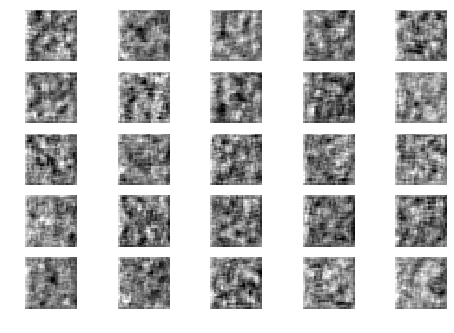

Epoch 2 Batch 910/937 [D loss: 0.279503, acc.: 93.75%] [G loss: 4.813219]
Epoch 2 Batch 911/937 [D loss: 0.137195, acc.: 87.50%] [G loss: 5.505988]
Epoch 2 Batch 912/937 [D loss: 0.009582, acc.: 100.00%] [G loss: 6.335238]
Epoch 2 Batch 913/937 [D loss: 0.283475, acc.: 87.50%] [G loss: 4.148475]
Epoch 2 Batch 914/937 [D loss: 0.085786, acc.: 96.88%] [G loss: 4.577004]
Epoch 2 Batch 915/937 [D loss: 0.058929, acc.: 96.88%] [G loss: 4.400035]
Epoch 2 Batch 916/937 [D loss: 0.017589, acc.: 100.00%] [G loss: 5.378195]
Epoch 2 Batch 917/937 [D loss: 0.016523, acc.: 100.00%] [G loss: 5.199718]
Epoch 2 Batch 918/937 [D loss: 0.050574, acc.: 100.00%] [G loss: 5.945011]


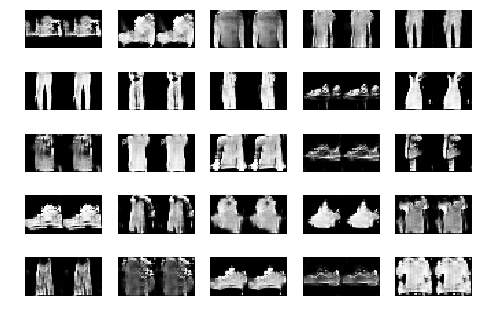

Epoch 2 Batch 919/937 [D loss: 0.295775, acc.: 93.75%] [G loss: 4.610686]
Epoch 2 Batch 920/937 [D loss: 0.055008, acc.: 96.88%] [G loss: 5.072612]
Epoch 2 Batch 921/937 [D loss: 0.090372, acc.: 96.88%] [G loss: 4.283673]
Epoch 2 Batch 922/937 [D loss: 0.126411, acc.: 90.62%] [G loss: 4.973898]
Epoch 2 Batch 923/937 [D loss: 0.187777, acc.: 90.62%] [G loss: 5.185851]
Epoch 2 Batch 924/937 [D loss: 0.021321, acc.: 100.00%] [G loss: 5.274327]
Epoch 2 Batch 925/937 [D loss: 0.025301, acc.: 100.00%] [G loss: 5.250066]
Epoch 2 Batch 926/937 [D loss: 0.117435, acc.: 96.88%] [G loss: 4.623013]
Epoch 2 Batch 927/937 [D loss: 0.071615, acc.: 100.00%] [G loss: 5.246929]
Epoch 2 Batch 928/937 [D loss: 0.098024, acc.: 96.88%] [G loss: 4.980263]
Epoch 2 Batch 929/937 [D loss: 0.011407, acc.: 100.00%] [G loss: 4.621408]
Epoch 2 Batch 930/937 [D loss: 0.011549, acc.: 100.00%] [G loss: 5.417413]
Epoch 2 Batch 931/937 [D loss: 0.086940, acc.: 96.88%] [G loss: 4.203242]
Epoch 2 Batch 932/937 [D loss: 0.

In [27]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain = 3)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


In [28]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6272)         633472      input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 7, 128)    0           dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 7, 7, 128)    512         reshape_1[0][0]                  
__________________________________________________________________________________________________
up_samplin

In [0]:
!rm -rf generator1fminst.h5



In [0]:

generator1.save('generator1fminst.h5')



In [0]:
files.download('generator1fminst.h5')


In [32]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


<class 'tensorflow.python.framework.ops.Tensor'>
(?, 28, 28, 1)
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 28, 28, 1)
merge layers
(?, 28, 28, 1)
(?, 28, 28, 1)
(?, 28, 56, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 7, 7, 128)    0           dense_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 

In [33]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=20, modeltotrain=2)

Number of examples:  30000.0
Number of Batches:  937
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


ValueError: ignored

In [0]:
!rm -rf generator2fmnist.h5


In [0]:

generator2.save('generator2fmnist.h5')

In [0]:
!ls -al


In [0]:
files.download('generator2fmnist.h5')

In [0]:
##!wget https://github.com/rajagopalmotivate/try1/raw/master/generatorTrainedepoch2git.h5

In [0]:
!rm -rf generator1fminst.h5

In [0]:
!ls -all

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator1fminst.h5

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
plotamodel(combined, showdetails=True )
files.download('model.png')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=1)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
plotamodel(combined)
files.download('model.png')

In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generator1fminst.h5')

!rm -rf generator2Trainedepoch2.h5

generator2.save('generator2fminst.h5')


In [0]:
generator1 = generator1.load_weights('generator1fmnist.h5')

In [0]:
generator2 = generator2.load_weights('generator2fmnist.h5')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [0]:
files.download('generator1fmnist.h5')

In [0]:
files.download('generator2fmnist.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

